In [1]:
from trenchripper.utils import kymo_handle,pandas_hdf5_handler,writedir
from trenchripper.segment import phase_segmentation, phase_segmentation_cluster
from trenchripper.cluster import dask_controller
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import os
import h5py
import resource

In [2]:
import dask

In [3]:
headpath = "/n/scratch2/bj66/vibrio_37_mux_salt_concentration"

In [4]:
segmenter = phase_segmentation_cluster(headpath, seg_channel="Phase")
segmenter.bit_max = None

In [5]:
data = segmenter.load_trench_array_list(np.random.randint(145))

TypeError: load_trench_array_list() missing 3 required positional arguments: 'file_idx', 'key', and 'to_8bit'

In [6]:
data.shape

(5, 1444, 590, 54)

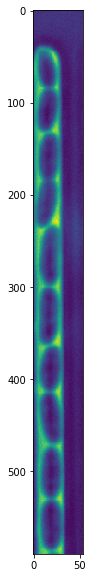

In [11]:
# trench = data[0,:]
trench = data[np.random.randint(data.shape[0]),:]
timepoint = np.random.randint(trench.shape[0])
img = trench[timepoint,:,:]
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.imshow(img)

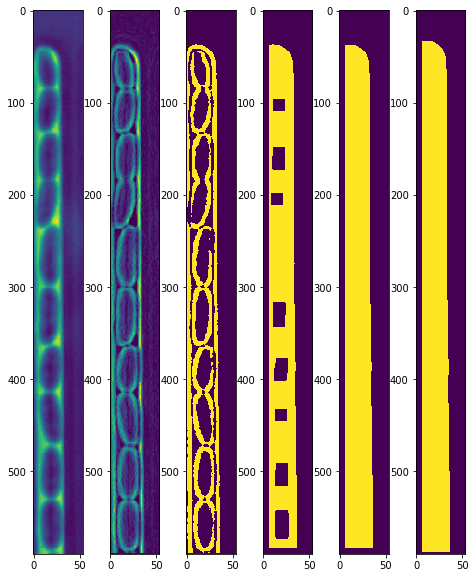

In [19]:
conn_comp, trench_masks, img_mask, maxima = segmenter.segment(img, return_all=True, show_plots=True)

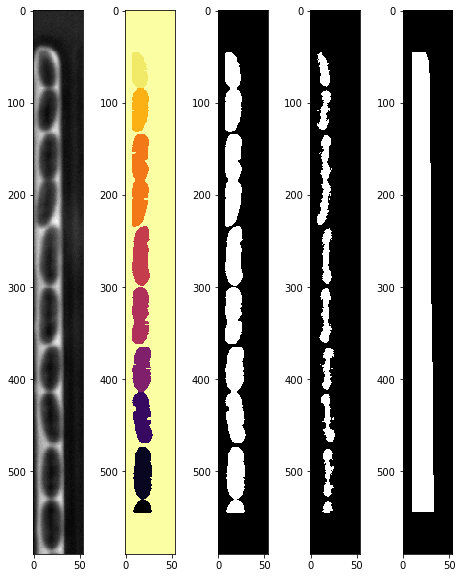

In [20]:
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(8,10))

ax1.imshow(img,cmap='gray')
ax2.imshow(conn_comp, cmap='inferno_r')
ax3.imshow(img_mask,cmap='gray')
ax4.imshow(maxima, cmap='gray')
if trench_masks is not None:
    ax5.imshow(trench_masks, cmap='gray')

In [17]:
dc = dask_controller(walltime='12:00:00',local=False,n_workers=50,memory='7.5GB',death_timeout=120.,working_directory=headpath+"/dask")
dc.startdask()
dc.daskcluster.start_workers()

/home/bj66/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [18]:
dc.displaydashboard()

In [19]:
segmenter.dask_segment(dc)

/home/bj66/TrenchRipper/trenchripper/utils.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [24]:
dc.shutdown()

Worker tcp://10.120.17.115:57266 restart in Job 54117789. This can be due to memory issue.
Worker tcp://10.120.17.62:59204 restart in Job 54117745. This can be due to memory issue.
Worker tcp://10.120.17.135:47913 restart in Job 54117765. This can be due to memory issue.
Worker tcp://10.120.16.98:56752 restart in Job 54117736. This can be due to memory issue.
Worker tcp://10.120.17.94:49606 restart in Job 54117751. This can be due to memory issue.
Worker tcp://10.120.17.94:57826 restart in Job 54117732. This can be due to memory issue.
Worker tcp://10.120.17.104:53890 restart in Job 54117764. This can be due to memory issue.
Worker tcp://10.120.17.104:47553 restart in Job 54117733. This can be due to memory issue.
Worker tcp://10.120.17.104:51539 restart in Job 54117781. This can be due to memory issue.
Worker tcp://10.120.17.109:55646 restart in Job 54117757. This can be due to memory issue.
Worker tcp://10.120.17.125:51913 restart in Job 54117777. This can be due to memory issue.
Wor

# Check results

In [5]:
file_idx = np.random.randint(200)
with h5py.File(segmenter.phasesegmentationpath + "/segmentation_" + str(file_idx) + ".hdf5","r") as input_file:
    data = input_file["data"][:]


File 83, Trench 2, Time 47


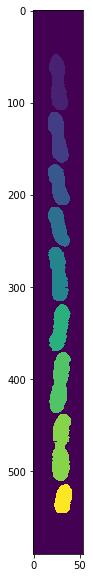

In [6]:
trench_idx = np.random.randint(data.shape[0])
time_idx = np.random.randint(data.shape[1])
img = data[trench_idx, time_idx,:,:]
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.imshow(img)
print("File %d, Trench %d, Time %d" %(file_idx, trench_idx, time_idx))

# Get loading fractions

In [5]:
dc = dask_controller(walltime='4:00:00',local=False,n_workers=40,memory='4GB',death_timeout=120.,working_directory=headpath+"/dask")
dc.startdask()
dc.daskcluster.start_workers()

In [6]:
dc.displaydashboard()

In [7]:
segmenter.dask_characterize_trench_loading(dc)

/home/bj66/TrenchRipper/trenchripper/utils.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [8]:
segmenter.dask_postprocess_trench_loading(dc)

KeyboardInterrupt: 

In [12]:
trench_loadings = np.concatenate(dc.daskclient.gather(dc.futures["Trench Loading"]), axis=0)


In [8]:
dc.shutdown()

Text(0.5, 0, 'Loading fraction')

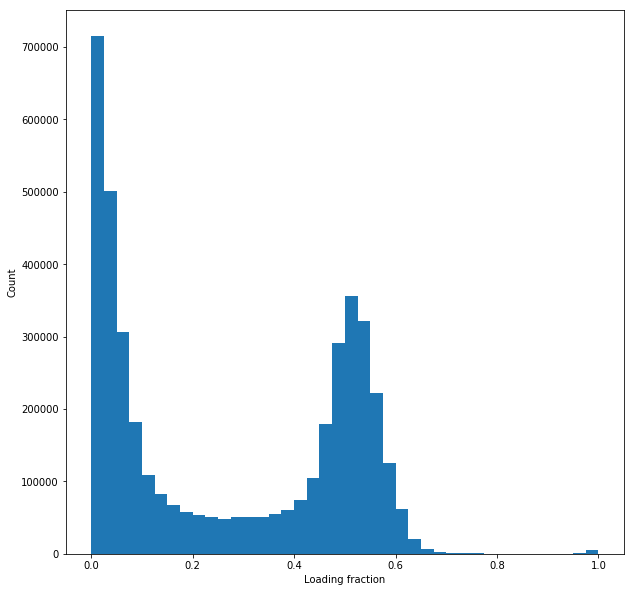

In [29]:
fig1, ax1= plt.subplots(figsize=(10,10))

ax1.hist(trench_loadings, bins=40)
ax1.set_ylabel("Count")
ax1.set_xlabel("Loading fraction")

# Test get cell properties

In [8]:
kymodf = segmenter.meta_handle.read_df("kymograph",read_metadata=True)


In [9]:
metadata = kymodf.metadata

In [15]:
kymodf = kymodf.reset_index()
kymodf = kymodf.set_index(["File Index", "File Trench Index", "timepoints"])

In [20]:
test = kymodf.loc[0]

In [29]:
len(kymodf.index.unique("File Trench Index"))

5

In [10]:
times = kymodf.loc[file_idx, "time (s)"]
global_trench_indices = kymodf.loc[file_idx, "trenchid"]
trench_loadings = kymodf.loc[file_idx, "Trench Loading"]

In [11]:
writedir(segmenter.phasedatapath,overwrite=True)

In [17]:
columns = ['area', 'bbox', 'centroid', 'convex_area', 'eccentricity',
       'equivalent_diameter', 'extent',   
       'label', 'major_axis_length', 
       'minor_axis_length','orientation', 'perimeter', 'solidity']

In [18]:
segmenter.extract_cell_data(file_idx, data, times, global_trench_indices, trench_loadings, columns, metadata)

KeyboardInterrupt: 

In [19]:
from pandas import HDFStore
store = HDFStore(os.path.join(segmenter.phasedatapath, "data_%d.h5" % file_idx))

In [20]:
testdf = store.get("metrics")

In [21]:
testdf.shape

(5303, 18)

In [22]:
testdf.tail(10)

area  convex_area  \
file_trench_index time_s       trench_cell_index                      
0                 44284.199903 3                  1406         1607   
                               4                   966         1085   
                  44344.009559 1                  2457         2851   
                               2                  2490         3108   
                               3                  1516         1732   
                               4                   736          805   
                  44404.163615 1                  2559         3021   
                               5                  2680         3313   
                               7                  1582         1782   
                               9                   512          552   

                                                  eccentricity  \
file_trench_index time_s       trench_cell_index                 
0                 44284.199903 3                      0.989176   
                               4                      0.971382   
                  44344.009559 1                      0.996090   
                               2                      0.995826   
                               3                      0.990249   
                               4                      0.952787   
                  44404.163615 1                      0.996376   
                               5                      0.996200   
                               7                      0.990328   
                               9                      0.912537   

                                                  equivalent_diameter  \
file_trench_index time_s       trench_cell_index                        
0                 44284.199903 3                            42.310457   
                               4                            35.070634   
                  44344.009559 1                            55.931651   
                               2                            56.306007   
                               3                            43.934396   
                               4                            30.612159   
                  44404.163615 1                            57.080820   
                               5                            58.414741   
                               7                            44.880563   
                               9                            25.532306   

                                                    extent  major_axis_length  \
file_trench_index time_s       trench_cell_index                                
0                 44284.199903 3                  0.751068         112.905823   
                               4                  0.696970          73.547997   
                  44344.009559 1                  0.756233         194.082511   
                               2                  0.654230         194.624214   
                               3                  0.751984         120.450847   
                               4                  0.801743          56.759250   
                  44404.163615 1                  0.756653         202.680095   
                               5                  0.654936         207.600377   
                               7                  0.642045         123.410342   
                               9                  0.728307          41.059987   

                                                  minor_axis_length  \
file_trench_index time_s       trench_cell_index                      
0                 44284.199903 3                          16.567310   
                               4                          17.469378   
                  44344.009559 1                          17.146464   
                               2                          17.763406   
                               3                          16.779623   
                               4                         

# Get cell properties

In [5]:
dc = dask_controller(walltime='8:00:00',local=False,n_workers=100,memory='4GB',death_timeout=120.,working_directory=headpath+"/dask")
dc.startdask()
dc.daskcluster.start_workers()

In [67]:
dc.daskcluster.scale(n=100)

In [6]:
dc.displaydashboard()

In [7]:
columns = ['area', 'bbox', 'centroid', 'convex_area', 'eccentricity',
       'equivalent_diameter', 'extent',   
       'label', 'major_axis_length', 
       'minor_axis_length','orientation', 'perimeter', 'solidity']
segmenter.dask_extract_cell_data(dc, columns)

/home/bj66/TrenchRipper/trenchripper/utils.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata
distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
distri

In [8]:
dc.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/bj66/anaconda3/lib/python3.7/site-packages/distributed/utils.py", line 656, in log_errors
    yield
  File "/home/bj66/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 1267, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/bj66/anaconda3/lib/python3.7/site-packages/distributed/utils.py", line 656, in log_errors
    yield
  File "/home/bj66/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 997, in _reconnect
    await self._close()
  File "/home/bj66/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 1267, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError

In [35]:
for key, value in dc.futures.items():
    if value.status == "finished":
        print(key)

Cell Props 9: 
Cell Props 201: 
Cell Props 287: 
Cell Props 369: 
Cell Props 413: 
Cell Props 432: 
Cell Props 508: 
Cell Props 571: 


# Check proprety extraction results

In [43]:
from pandas import HDFStore
import pandas as pd
import random
file_idx = 9
p = os.path.join(segmenter.phasedatapath, "data_%d.h5" % file_idx)
test_df = pd.read_hdf(p)

In [48]:
test_df.head(3)

area  convex_area  eccentricity  \
file_trench_index time_s   trench_cell_index                                    
0                 0.465383 1                   429          439      0.744662   
                           2                   568          586      0.810096   
                           3                   672          726      0.917120   

                                              equivalent_diameter    extent  \
file_trench_index time_s   trench_cell_index                                  
0                 0.465383 1                            23.371345  0.717391   
                           2                            26.892379  0.759358   
                           3                            29.250931  0.615385   

                                              major_axis_length  \
file_trench_index time_s   trench_cell_index                      
0                 0.465383 1                          28.651704   
                           2                          35.201725   
                           3                          46.902952   

                                              minor_axis_length  orientation  \
file_trench_index time_s   trench_cell_index                                   
0                 0.465383 1                          19.123333     0.994763   
                           2                          20.638681     1.357779   
                           3                          18.696061    -1.262742   

                                               perimeter  solidity  min_row  \
file_trench_index time_s   trench_cell_index                                  
0                 0.465383 1                   77.840620  0.977221       47   
                           2                   91.840620  0.969283       74   
                           3                  112.568542  0.925620      111   

                                              min_col  max_row  max_col  \
file_trench_index time_s   trench_cell_index                              
0                 0.465383 1                       11       73       34   
                           2                       15      108       37   
                           3                       12      153       38   

                                                   centx      centy  \
file_trench_index time_s   trench_cell_index                          
0                 0.465383 1                   59.634033  22.200466   
                           2                   90.940141  25.846831   
                           3                  131.270833  24.916667   

                                              trench_loadings  trenchid  
file_trench_index time_s   trench_cell_index                             
0                 0.465383 1                         0.505154        45  
                           2                         0.505154        45  
                           3                         0.505154        45

In [45]:
trenches = list(test_df.index.unique("file_trench_index"))
random.shuffle(trenches)
trench_idx = trenches[0]
time_idx = 0

File 9, Trench 3, Time 0


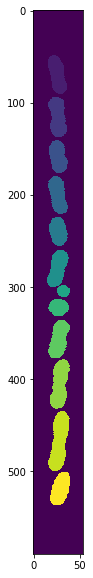

In [46]:
# Show segmentation mask
with h5py.File(segmenter.phasesegmentationpath + "/segmentation_" + str(file_idx) + ".hdf5","r") as input_file:
    data = input_file["data"][:]
    img = data[trench_idx, time_idx,:,:]
    fig1, ax1 = plt.subplots(figsize=(10,10))
    ax1.imshow(img)
    print("File %d, Trench %d, Time %d" %(file_idx, trench_idx, time_idx))

In [57]:
times = test_df.loc[trench_idx].index.unique("time_s")

trench_cell_index
1      69.691297
2     115.672938
3     158.644876
4     200.041204
5     239.856566
6     279.389937
7     304.080000
8     321.981928
9     356.513473
10    405.786420
11    467.611279
12    519.003413
Name: centx, dtype: float64

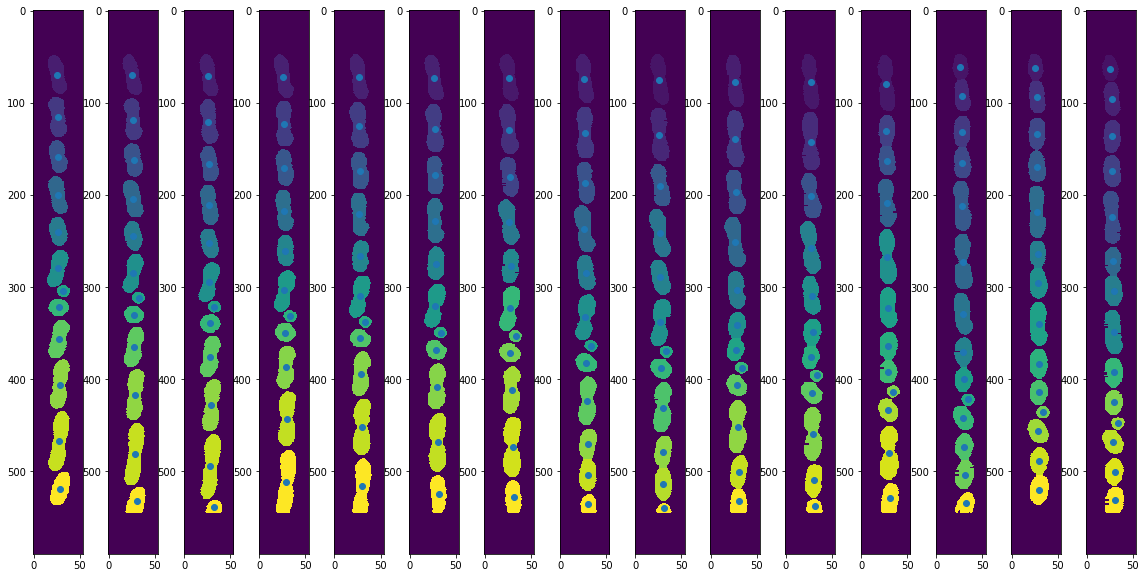

In [64]:
fig1, axes = plt.subplots(1, 15, figsize=(20, 10))
for i, ax in enumerate(axes):
    ax.imshow(data[trench_idx, time_idx+i,:,:])
    ax.scatter(test_df.loc[trench_idx, times[time_idx+i]]["centy"], test_df.loc[trench_idx, times[time_idx+i]]["centx"])